In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("Datasets/train_values.csv").set_index('building_id')

In [3]:
damages = pd.read_csv("Datasets/train_labels.csv").set_index('building_id')

# Whole dataset

In [4]:
df.shape

(260601, 38)

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
geo_level_1_id,260601.0,13.900353,8.033617,0.0,7.0,12.0,21.0,30.0
geo_level_2_id,260601.0,701.074685,412.710734,0.0,350.0,702.0,1050.0,1427.0
geo_level_3_id,260601.0,6257.876148,3646.369645,0.0,3073.0,6270.0,9412.0,12567.0
count_floors_pre_eq,260601.0,2.129723,0.727665,1.0,2.0,2.0,2.0,9.0
age,260601.0,26.535029,73.565937,0.0,10.0,15.0,30.0,995.0
area_percentage,260601.0,8.018051,4.392231,1.0,5.0,7.0,9.0,100.0
height_percentage,260601.0,5.434365,1.918418,2.0,4.0,5.0,6.0,32.0
has_superstructure_adobe_mud,260601.0,0.088645,0.284231,0.0,0.0,0.0,0.0,1.0
has_superstructure_mud_mortar_stone,260601.0,0.761935,0.425900,0.0,1.0,1.0,1.0,1.0
has_superstructure_stone_flag,260601.0,0.034332,0.182081,0.0,0.0,0.0,0.0,1.0


# Damages

Let's begin with insights about the target

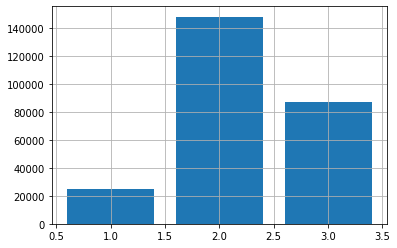

In [6]:
damages['damage_grade'].hist(align="mid", rwidth=0.8, 
                   bins=np.arange(1, 5)-0.5)

In [7]:
damages['damage_grade'].value_counts()/len(damages)*100

2    56.891186
3    33.468022
1     9.640792
Name: damage_grade, dtype: float64

In [8]:
damages['damage_grade'].mean()

2.2382723013342236

 # Geo Levels exploration


geo_level_1_id, geo_level_2_id, geo_level_3_id (type: int): geographic region in which building exists, from largest (level 1) to most specific sub-region (level 3). Possible values: level 1: 0-30, level 2: 0-1427, level 3: 0-12567.

I will first take a look at the repartition of each geo level 1 ID in the dataset

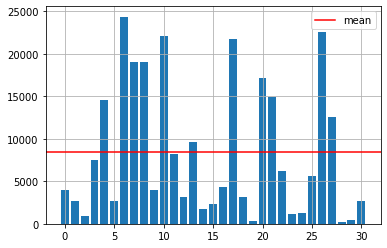

In [9]:
col = 'geo_level_1_id'
df.loc[:,col].hist(align="mid", rwidth=0.8, 
                   bins=np.arange(min(df.loc[:,col]), max(df.loc[:,col])+2)-0.5)
plt.axhline(df.loc[:,col].value_counts().mean(), color='r')
plt.legend(labels=["mean"])

Geo leveld 1 ID are distributed unevenly in the dataset. It may be a problem later during learning step.

Let's now visualize the probabilities of damages level in each geo level 1 ID. The redder is a cell, the higher is the probability.

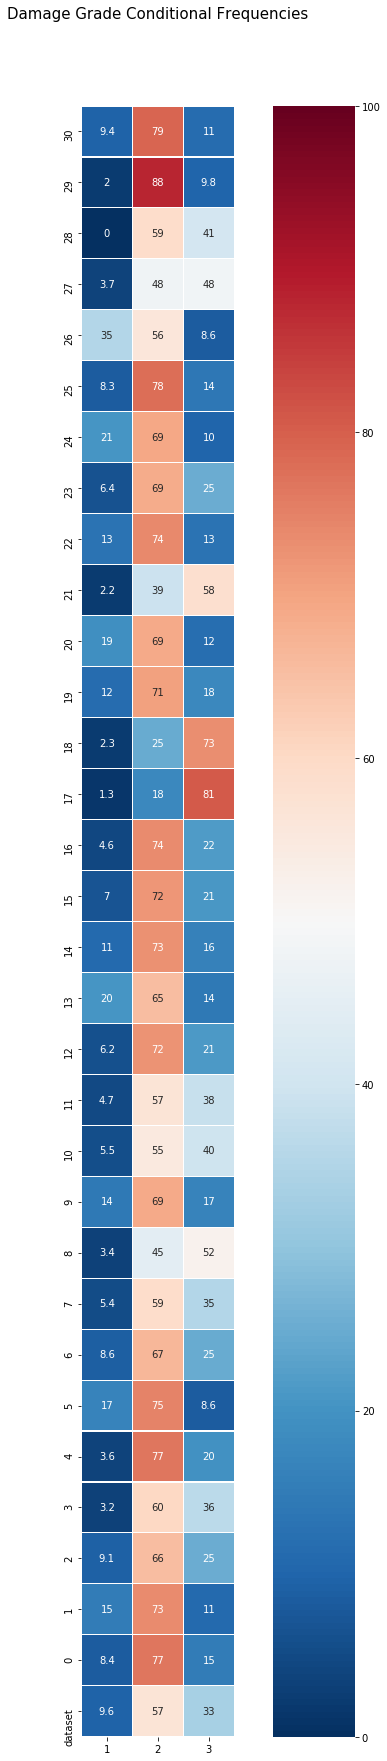

In [10]:
dmgs = df.merge(damages, right_index=True, left_index=True).loc[:,[col,'damage_grade']]
cmap = pd.DataFrame(columns=np.arange(0,31), index=np.arange(1,4)).fillna(0)
for i in range(0,31):
    cmap[i] = dmgs[dmgs[col] == i]['damage_grade'].value_counts().sort_index()/len(dmgs[dmgs[col] == i])*100
cmap = cmap.T.fillna(0)
cmap = cmap.sort_index(ascending=False)
cmap.loc["dataset",:] = damages['damage_grade'].value_counts()/len(damages)*100
colormap = plt.cm.RdBu_r
plt.figure(figsize=(14,30))
plt.title('Damage Grade Conditional Frequencies', y=1.05, size=15)
sns.heatmap(cmap.fillna(100).astype(float) ,linewidths=0.1, vmax=100, vmin=0,
            square=True, cmap=colormap, linecolor='white', annot=True)

The distribution of damages in the geo level 1 ID is quite homogeneous. However, some seem to be an asset (26, 24, 20, 13) and others seem to be a flaw (21, 18, 17).

The tab below give the mean of damages for each geo level 1 ID.

In [11]:
expected_value = pd.DataFrame(index=cmap.index, columns=["mean_damage", "frequency"])
for i in expected_value.index:
    expected_value.loc[i,"mean_damage"] = cmap.loc[i,1]+cmap.loc[i,2]*2+cmap.loc[i,3]*3
expected_value["frequency"] = df[col].value_counts().sort_index()/len(df)*100
expected_value.sort_values(by="mean_damage")

,mean_damage,frequency
26,173.089,8.678017
24,189.466,0.502684
5,191.97,1.032229
20,192.646,6.606268
13,193.766,3.686862
1,196.076,1.036450
22,200.096,2.399070
30,202.048,1.030694
9,202.602,1.518797
14,204.959,0.657710


Let's now get insights of geo level2 ID - which are subdivision of geo level1 ID.

In [12]:
dmgs = df.merge(damages, right_index=True, left_index=True).loc[:,['geo_level_2_id','damage_grade']]
cmap = pd.DataFrame(columns=np.sort(df['geo_level_2_id'].unique()), index=np.arange(1,4)).fillna(0)
for i in cmap.columns:
    cmap[i] = dmgs[dmgs['geo_level_2_id'] == i]['damage_grade'].value_counts().sort_index()/len(dmgs[dmgs['geo_level_2_id'] == i])
cmap = cmap.T.fillna(0)
cmap.loc["dataset",:] = damages['damage_grade'].value_counts()/len(damages)
expected_value = pd.DataFrame(index=cmap.index, columns=["mean_damage", "frequency*100"])
for i in expected_value.index:
    expected_value.loc[i,"mean_damage"] = cmap.loc[i,1]+cmap.loc[i,2]*2+cmap.loc[i,3]*3
expected_value["frequency*100"] = df['geo_level_2_id'].value_counts().sort_index()/len(df)*100
expected_value.sort_values(by="mean_damage")

,mean_damage,frequency*100
115,1,0.000384
1263,1,0.000384
688,1,0.000384
1043,1,0.000384
14,1.21818,0.042210
1228,1.22642,0.020338
557,1.23148,0.041443
428,1.25,0.003070
498,1.25,0.001535
301,1.25,0.001535


There are too many geo level2 ID. I will either drop this feature or substitute geo level 1&2(&3) by the expected damage value of geo level 2.

# Count floors of buildings

count_floors_pre_eq (type: int): number of floors in the building before the earthquake.

In [13]:
col = 'count_floors_pre_eq'
df[col].describe()

count    260601.000000
mean          2.129723
std           0.727665
min           1.000000
25%           2.000000
50%           2.000000
75%           2.000000
max           9.000000
Name: count_floors_pre_eq, dtype: float64

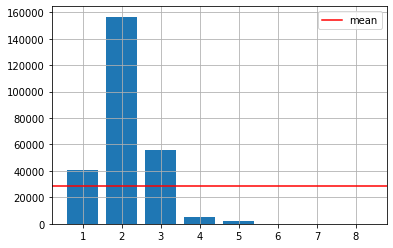

In [14]:
df[col].hist(align="mid", rwidth=0.8, 
                               bins=np.arange(min(df[col]), max(df[col])+1)-0.5)
plt.axhline(df.loc[:,col].value_counts().mean(), color='r')
plt.legend(labels=["mean"])

In [15]:
df[col].value_counts()

2    156623
3     55617
1     40441
4      5424
5      2246
6       209
7        39
9         1
8         1
Name: count_floors_pre_eq, dtype: int64

There are very few buildings with more than 6 floors : they are clearly outliers

Once again let's visualize the probabilities of damages level for each floor count. I added the probabilities of the wholedataset for comparison

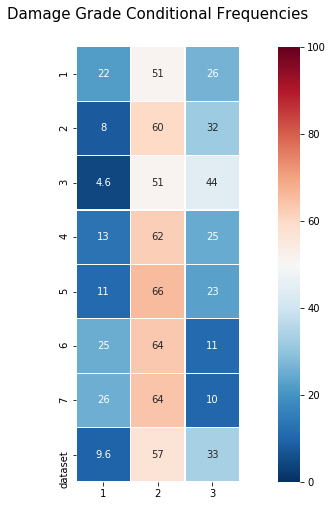

In [16]:
dmgs = df.merge(damages, right_index=True, left_index=True).loc[:,[col,'damage_grade']]
cmap = pd.DataFrame(columns=np.arange(1,8), index=np.arange(1,4)).fillna(0)
for i in range(1,8):
    cmap[i] = dmgs[dmgs[col] == i]['damage_grade'].value_counts().sort_index()/len(dmgs[dmgs[col] == i])*100
cmap = cmap.T.fillna(0)
cmap.loc["dataset",:] = damages['damage_grade'].value_counts()/len(damages)*100
colormap = plt.cm.RdBu_r
plt.figure(figsize=(14,8))
plt.title('Damage Grade Conditional Frequencies', y=1.05, size=15)
sns.heatmap(cmap.fillna(100).astype(float) ,linewidths=0.1, vmax=100, vmin=0,
            square=True, cmap=colormap, linecolor='white', annot=True)

Let's plot the mean of damages level against count floors of building. I added the mean of the wholedataset for comparison.

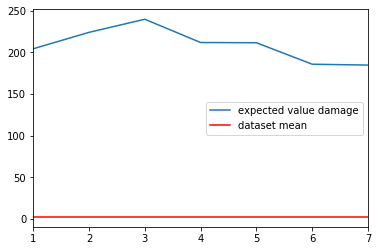

In [17]:
cmap = cmap.drop(index="dataset")
expected_value = pd.DataFrame(index=cmap.index, columns=["expected_value_damage", "frequency"])
for i in expected_value.index:
    expected_value.loc[i,"expected_value_damage"] = cmap.loc[i,1]+cmap.loc[i,2]*2+cmap.loc[i,3]*3
expected_value["frequency"] = df[col].value_counts().sort_index()/len(df)*100
expected_value.plot(y="expected_value_damage")
plt.axhline(damages['damage_grade'].mean(), color='r')
plt.legend(labels=["expected value damage", "dataset mean"])

In [18]:
expected_value = expected_value.sort_index()
expected_value.loc["dataset","expected_value_damage"] = damages['damage_grade'].mean()
expected_value

,expected_value_damage,frequency
1,204.216,15.518359
2,223.923,60.100690
3,239.671,21.341821
4,211.726,2.081343
5,211.443,0.861854
6,185.646,0.080199
7,184.615,0.014965
dataset,2.23827,NaN


There is no specific conclusion here : the floors count is not obviously related to the damage grade level

# Age of buildings

age (type: int): age of the building in years.

In [19]:
col = "age"
df[col].describe()

count    260601.000000
mean         26.535029
std          73.565937
min           0.000000
25%          10.000000
50%          15.000000
75%          30.000000
max         995.000000
Name: age, dtype: float64

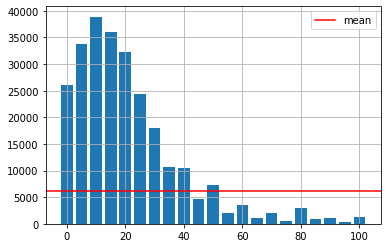

In [20]:
df[col].hist(align="mid", rwidth=0.8, 
                               bins=np.arange(min(df[col]), 100+10, 5)-2.5)
plt.axhline(df.loc[:,col].value_counts().mean(), color='r')
plt.legend(labels=["mean"])

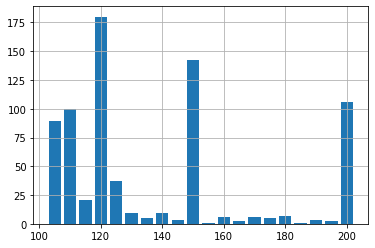

In [21]:
df[col].hist(align="mid", rwidth=0.8, 
                               bins=np.arange(105, 200+10, 5)-2.5)

In [22]:
len(df[df[col] == 995])

1390

995-years old buildings are most likely errors. I will remove them from training set. There are very few buildings with aged more than 100 : they are clearly outliers.

Let's plot the mean of damages level against age of building. I added the mean of the wholedataset for comparison

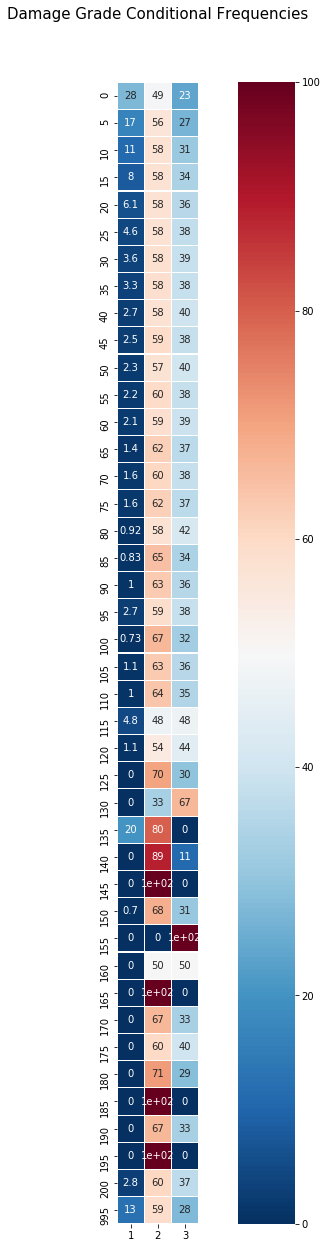

In [23]:
dmgs = df.merge(damages, right_index=True, left_index=True).loc[:,[col,'damage_grade']]
cmap = pd.DataFrame(columns=np.sort(df[col].unique()), index=np.arange(1,4)).fillna(0)
for i in cmap.columns:
    cmap[i] = dmgs[dmgs[col] == i]['damage_grade'].value_counts().sort_index()/len(dmgs[dmgs[col] == i])*100
cmap = cmap.T.fillna(0)
colormap = plt.cm.RdBu_r
plt.figure(figsize=(14,21))
plt.title('Damage Grade Conditional Frequencies', y=1.05, size=15)
sns.heatmap(cmap.fillna(100).astype(float) ,linewidths=0.1, vmax=100, vmin=0,
            square=True, cmap=colormap, linecolor='white', annot=True)

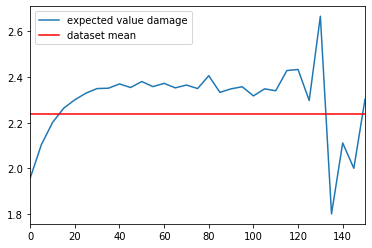

In [24]:
expected_value = pd.DataFrame(index=cmap.index, columns=["expected_value_damage", "frequency"])
for i in expected_value.index:
    expected_value.loc[i,"expected_value_damage"] = cmap.loc[i,1]+cmap.loc[i,2]*2+cmap.loc[i,3]*3
expected_value["frequency"] = df[col].value_counts().sort_index()/len(df)*100
(expected_value.loc[:150,:]/100).plot(y="expected_value_damage")
plt.axhline(damages['damage_grade'].mean(), color='r')
plt.legend(labels=["expected value damage", "dataset mean"])

In [25]:
len(dmgs[dmgs[col]<105])/len(dmgs)

0.9918496091726432

In [26]:
dmgs[dmgs[col]>100]["damage_grade"].mean(), dmgs[dmgs[col]==100]["damage_grade"].mean()

(2.220809792843691, 2.317448680351906)

In [27]:
cmap.loc[105:,:].mean(), cmap.loc[100,:]

(1     2.114701
 2    66.860150
 3    31.025149
 dtype: float64, 1     0.733138
 2    66.788856
 3    32.478006
 Name: 100, dtype: float64)

This is an interesting curve. We can remove buildings aged more than 100 years from the training set (0.82% of buildings) and lower them to 100 years in the test set (because damages probabilities are really close so it won't affect predictions).

# Area percentage of buildings

In [28]:
col = 'area_percentage'
df[col].describe()

count    260601.000000
mean          8.018051
std           4.392231
min           1.000000
25%           5.000000
50%           7.000000
75%           9.000000
max         100.000000
Name: area_percentage, dtype: float64

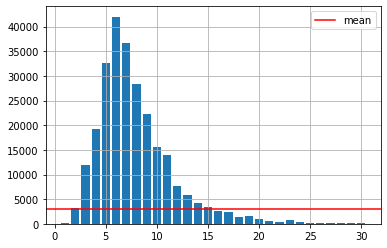

In [29]:
df[col].hist(align="mid", rwidth=0.8, 
                               bins=np.arange(min(df[col]), 30+2)-0.5)
plt.axhline(df.loc[:,col].value_counts().mean(), color='r')
plt.legend(labels=["mean"])

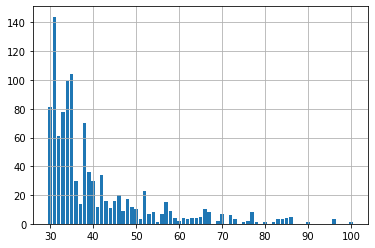

In [30]:
df[col].hist(align="mid", rwidth=0.8, 
                               bins=np.arange(30, 100+2)-0.5)

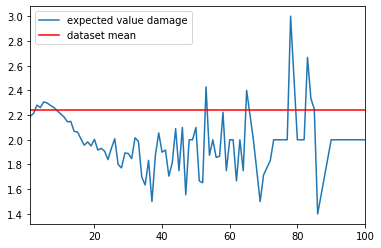

In [31]:
dmgs = df.merge(damages, right_index=True, left_index=True).loc[:,[col,'damage_grade']]
cmap = pd.DataFrame(columns=np.sort(df[col].unique()), index=np.arange(1,4)).fillna(0)
for i in cmap.columns:
    cmap[i] = dmgs[dmgs[col] == i]['damage_grade'].value_counts().sort_index()/len(dmgs[dmgs[col] == i])
cmap = cmap.T.fillna(0)
expected_value = pd.DataFrame(index=cmap.index, columns=["expected_value_damage", "frequency"])
for i in expected_value.index:
    expected_value.loc[i,"expected_value_damage"] = cmap.loc[i,1]+cmap.loc[i,2]*2+cmap.loc[i,3]*3
expected_value["frequency"] = df[col].value_counts().sort_index()/len(df)*100
expected_value.plot(y="expected_value_damage")
plt.axhline(damages['damage_grade'].mean(), color='r')
plt.legend(labels=["expected value damage", "dataset mean"])

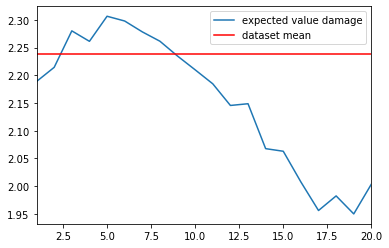

In [32]:
dmgs = df.merge(damages, right_index=True, left_index=True).loc[:,[col,'damage_grade']]
cmap = pd.DataFrame(columns=np.sort(df[col].unique()), index=np.arange(1,4)).fillna(0)
for i in cmap.columns:
    cmap[i] = dmgs[dmgs[col] == i]['damage_grade'].value_counts().sort_index()/len(dmgs[dmgs[col] == i])
cmap = cmap.T.fillna(0)
expected_value = pd.DataFrame(index=cmap.index, columns=["expected_value_damage", "frequency"])
for i in expected_value.index:
    expected_value.loc[i,"expected_value_damage"] = cmap.loc[i,1]+cmap.loc[i,2]*2+cmap.loc[i,3]*3
expected_value["frequency"] = df[col].value_counts().sort_index()/len(df)*100
expected_value.loc[:20,:].plot(y="expected_value_damage")
plt.axhline(damages['damage_grade'].mean(), color='r')
plt.legend(labels=["expected value damage", "dataset mean"])

In [33]:
expected_value["frequency"][:20]

1      0.034536
2      1.220640
3      4.542193
4      7.381399
5     12.557128
6     16.121581
7     14.102785
8     10.915154
9      8.518386
10     5.991151
11     5.336511
12     2.909045
13     2.231381
14     1.597078
15     1.338828
16     0.999996
17     0.955100
18     0.505370
19     0.614733
20     0.404066
Name: frequency, dtype: float64

In [34]:
len(dmgs[dmgs[col]<17])/len(dmgs)

0.9579779049197816

In [35]:
dmgs[dmgs[col]>17]["damage_grade"].mean(), dmgs[dmgs[col]==17]["damage_grade"].mean()

(1.929567478137556, 1.9562073121735637)

In [36]:
cmap.loc[17:,:].mean(), cmap.loc[17,:]

(1    0.257166
 2    0.541736
 3    0.201098
 dtype: float64, 1    0.254319
 2    0.535155
 3    0.210526
 Name: 17, dtype: float64)

Damages probabilities are really close : it could be interesting to group together buildings with area percentage >= 17

# Height percentage 

In [37]:
col = "height_percentage"
df[col].describe()

count    260601.000000
mean          5.434365
std           1.918418
min           2.000000
25%           4.000000
50%           5.000000
75%           6.000000
max          32.000000
Name: height_percentage, dtype: float64

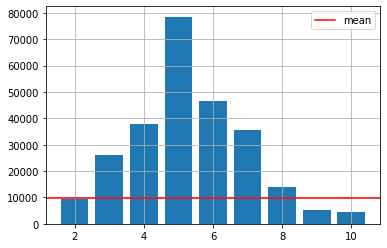

In [38]:
df[col].hist(align="mid", rwidth=0.8, 
                               bins=np.arange(min(df[col]), 10+2)-0.5)
plt.axhline(df.loc[:,col].value_counts().mean(), color='r')
plt.legend(labels=["mean"])

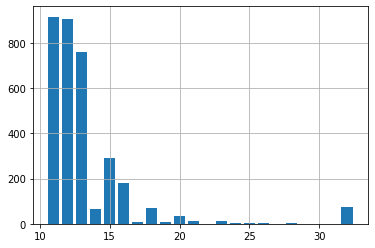

In [39]:
df[col].hist(align="mid", rwidth=0.8, 
                               bins=np.arange(11, 32+2)-0.5)

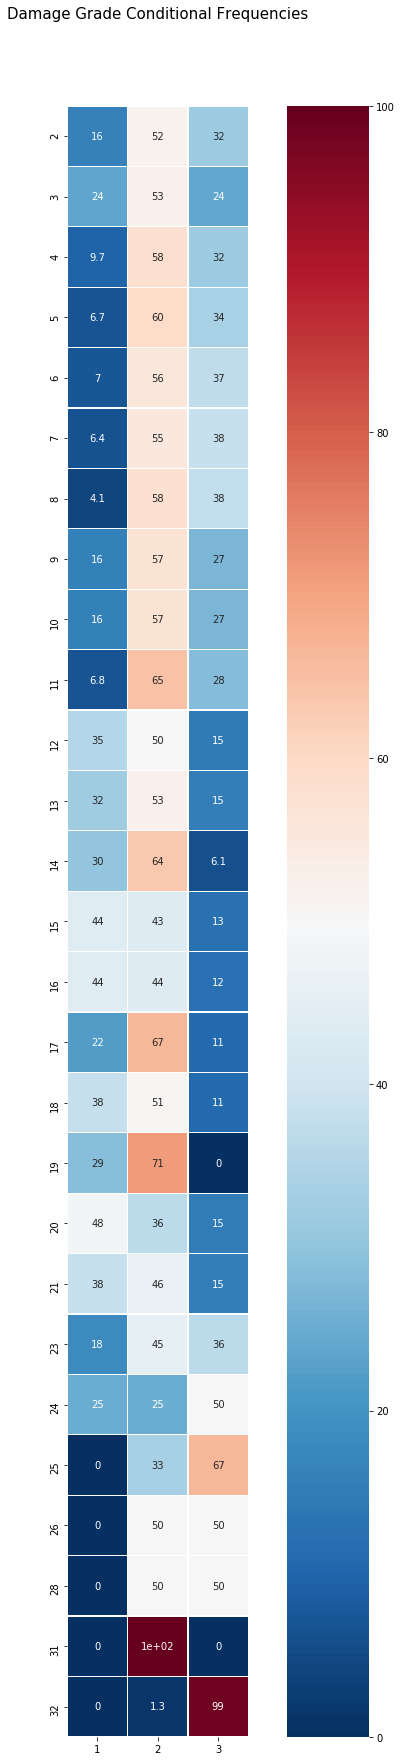

In [40]:
dmgs = df.merge(damages, right_index=True, left_index=True).loc[:,[col,'damage_grade']]
cmap = pd.DataFrame(columns=np.sort(df[col].unique()), index=np.arange(1,4)).fillna(0)
for i in cmap.columns:
    cmap[i] = dmgs[dmgs[col] == i]['damage_grade'].value_counts().sort_index()/len(dmgs[dmgs[col] == i])*100
cmap = cmap.T.fillna(0)
colormap = plt.cm.RdBu_r
plt.figure(figsize=(14,30))
plt.title('Damage Grade Conditional Frequencies', y=1.05, size=15)
sns.heatmap(cmap.fillna(100).astype(float) ,linewidths=0.1, vmax=100, vmin=0,
            square=True, cmap=colormap, linecolor='white', annot=True)

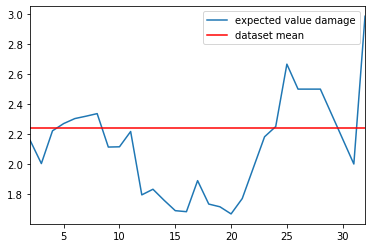

In [41]:
expected_value = pd.DataFrame(index=cmap.index, columns=["expected_value_damage", "frequency"])
for i in expected_value.index:
    expected_value.loc[i,"expected_value_damage"] = cmap.loc[i,1]+cmap.loc[i,2]*2+cmap.loc[i,3]*3
expected_value["frequency"] = df[col].value_counts().sort_index()/len(df)*100
(expected_value/100).plot(y="expected_value_damage")
plt.axhline(damages['damage_grade'].mean(), color='r')
plt.legend(labels=["expected value damage", "dataset mean"])

In [42]:
expected_value.loc["dataset","expected_value_damage"] = damages['damage_grade'].mean()
expected_value.sort_values(by="expected_value_damage")

,expected_value_damage,frequency
dataset,2.23827,NaN
20,166.667,0.012663
16,168.156,0.068687
15,168.836,0.112049
19,171.429,0.002686
18,173.239,0.027245
14,175.758,0.025326
21,176.923,0.004988
12,179.383,0.348042
13,183.136,0.291250


In [43]:
cmap.loc[:9,:]

,1,2,3
2,16.141859,52.025793,31.832348
3,23.585160,52.533035,23.881805
4,9.670842,58.488468,31.840691
5,6.725001,59.548100,33.726899
6,7.033587,55.597392,37.369021
7,6.386578,55.308050,38.305371
8,4.128902,58.099554,37.771544
9,15.736607,57.217262,27.046131


There is nothing interesting here : for well-represented values (from 2 to 8), damages probabilities are close to the dataset one's.

# Count families

count_families (type: int): number of families that live in the building.

In [44]:
col = "count_families"
df[col].describe()

count    260601.000000
mean          0.983949
std           0.418389
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           9.000000
Name: count_families, dtype: float64

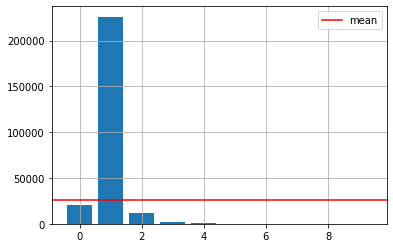

In [45]:
df[col].hist(align="mid", rwidth=0.8, 
                               bins=np.arange(min(df[col]), 9+2)-0.5)
plt.axhline(df.loc[:,col].value_counts().mean(), color='r')
plt.legend(labels=["mean"])

In [46]:
len(df[df[col] == 1])/len(df)

0.8676674302861462

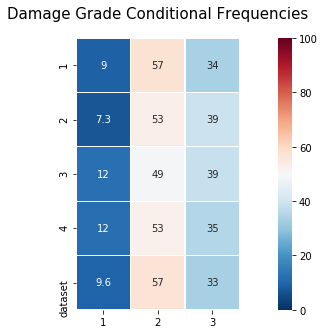

In [47]:
dmgs = df.merge(damages, right_index=True, left_index=True).loc[:,[col,'damage_grade']]
cmap = pd.DataFrame(columns=np.arange(1,5), index=np.arange(1,4)).fillna(0)
for i in range(1,5):
    cmap[i] = dmgs[dmgs[col] == i]['damage_grade'].value_counts().sort_index()/len(dmgs[dmgs[col] == i])*100
cmap = cmap.T.fillna(0)
cmap.loc["dataset",:] = damages['damage_grade'].value_counts()/len(damages)*100
colormap = plt.cm.RdBu_r
plt.figure(figsize=(14,5))
plt.title('Damage Grade Conditional Frequencies', y=1.05, size=15)
sns.heatmap(cmap.fillna(100).astype(float) ,linewidths=0.1, vmax=100, vmin=0,
            square=True, cmap=colormap, linecolor='white', annot=True)

count_families == 1 is 87% of the dataset: this value is over-represented so this feature will not be very useful for training. I will consider remove it.

# Land surface condition

land_surface_condition (type: categorical): surface condition of the land where the building was built. Possible values: n, o, t.

In [48]:
col = "land_surface_condition"
df[col].value_counts()

t    216757
n     35528
o      8316
Name: land_surface_condition, dtype: int64

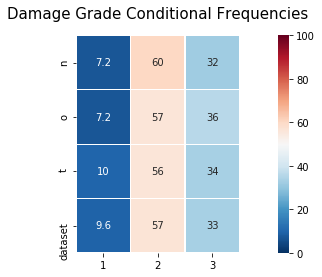

In [49]:
dmgs = df.merge(damages, right_index=True, left_index=True).loc[:,[col,'damage_grade']]
cmap = pd.DataFrame(columns=np.sort(df[col].unique()), index=np.arange(1,4)).fillna(0)
for i in cmap.columns:
    cmap[i] = dmgs[dmgs[col] == i]['damage_grade'].value_counts().sort_index()/len(dmgs[dmgs[col] == i])*100
cmap = cmap.T.fillna(0)
cmap.loc["dataset",:] = damages['damage_grade'].value_counts()/len(damages)*100
colormap = plt.cm.RdBu_r
plt.figure(figsize=(14,4))
plt.title('Damage Grade Conditional Frequencies', y=1.05, size=15)
sns.heatmap(cmap.fillna(100).astype(float) ,linewidths=0.1, vmax=100, vmin=0,
            square=True, cmap=colormap, linecolor='white', annot=True)

In [50]:
expected_value = pd.DataFrame(index=cmap.index, columns=["expected_value_damage", "frequency"])
for i in expected_value.index:
    expected_value.loc[i,"expected_value_damage"] = cmap.loc[i,1]+cmap.loc[i,2]*2+cmap.loc[i,3]*3
expected_value["frequency"] = df[col].value_counts().sort_index()/len(df)*100
(expected_value/100).sort_values(by="expected_value_damage")

,expected_value_damage,frequency
t,2.23417,0.831758
dataset,2.23827,NaN
n,2.25141,0.136331
o,2.28908,0.031911


One category (t) is over-represented in this feature. I will consider remove the feature, or merge together the 2 others (n and o)

# Foundation

foundation_type (type: categorical): type of foundation used while building. Possible values: h, i, r, u, w.

In [51]:
col = "foundation_type"
df[col].value_counts()

r    219196
w     15118
u     14260
i     10579
h      1448
Name: foundation_type, dtype: int64

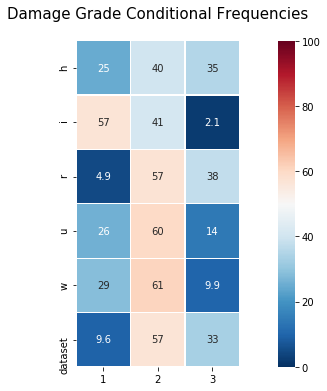

In [52]:
dmgs = df.merge(damages, right_index=True, left_index=True).loc[:,[col,'damage_grade']]
cmap = pd.DataFrame(columns=np.sort(df[col].unique()), index=np.arange(1,4)).fillna(0)
for i in cmap.columns:
    cmap[i] = dmgs[dmgs[col] == i]['damage_grade'].value_counts().sort_index()/len(dmgs[dmgs[col] == i])*100
cmap = cmap.T.fillna(0)
cmap.loc["dataset",:] = damages['damage_grade'].value_counts()/len(damages)*100
colormap = plt.cm.RdBu_r
plt.figure(figsize=(14,6))
plt.title('Damage Grade Conditional Frequencies', y=1.05, size=15)
sns.heatmap(cmap.fillna(100).astype(float) ,linewidths=0.1, vmax=100, vmin=0,
            square=True, cmap=colormap, linecolor='white', annot=True)

In [53]:
expected_value = pd.DataFrame(index=cmap.index, columns=["expected_value_damage", "frequency"])
for i in expected_value.index:
    expected_value.loc[i,"expected_value_damage"] = cmap.loc[i,1]+cmap.loc[i,2]*2+cmap.loc[i,3]*3
expected_value["frequency"] = df[col].value_counts().sort_index()/len(df)*100
(expected_value/100).sort_values(by="expected_value_damage")

,expected_value_damage,frequency
i,1.45335,0.040595
w,1.81095,0.058012
u,1.88366,0.054720
h,2.10566,0.005556
dataset,2.23827,NaN
r,2.32957,0.841117


Each category have very different damages probabilities so this feature will be very useful for training.

# Roof type

roof_type (type: categorical): type of roof used while building. Possible values: n, q, x.

In [54]:
col = "roof_type"
df[col].value_counts()

n    182842
q     61576
x     16183
Name: roof_type, dtype: int64

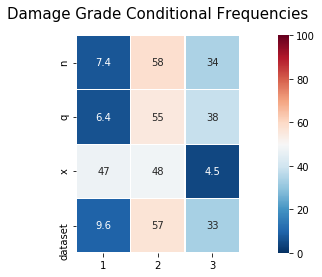

In [55]:
dmgs = df.merge(damages, right_index=True, left_index=True).loc[:,[col,'damage_grade']]
cmap = pd.DataFrame(columns=np.sort(df[col].unique()), index=np.arange(1,4)).fillna(0)
for i in cmap.columns:
    cmap[i] = dmgs[dmgs[col] == i]['damage_grade'].value_counts().sort_index()/len(dmgs[dmgs[col] == i])*100
cmap = cmap.T.fillna(0)
cmap.loc["dataset",:] = damages['damage_grade'].value_counts()/len(damages)*100
colormap = plt.cm.RdBu_r
plt.figure(figsize=(14,4))
plt.title('Damage Grade Conditional Frequencies', y=1.05, size=15)
sns.heatmap(cmap.fillna(100).astype(float) ,linewidths=0.1, vmax=100, vmin=0,
            square=True, cmap=colormap, linecolor='white', annot=True)

In [56]:
expected_value = pd.DataFrame(index=cmap.index, columns=["expected_value_damage", "frequency"])
for i in expected_value.index:
    expected_value.loc[i,"expected_value_damage"] = cmap.loc[i,1]+cmap.loc[i,2]*2+cmap.loc[i,3]*3
expected_value["frequency"] = df[col].value_counts().sort_index()/len(df)*100
(expected_value/100).sort_values(by="expected_value_damage")

,expected_value_damage,frequency
x,1.57227,0.062099
dataset,2.23827,NaN
n,2.26964,0.701617
q,2.32017,0.236285


Each category have very different damages probabilities so this feature will be very useful for training.

# Ground floor type

ground_floor_type (type: categorical): type of the ground floor. Possible values: f, m, v, x, z.

In [57]:
col = "ground_floor_type"
df[col].value_counts()

f    209619
x     24877
v     24593
z      1004
m       508
Name: ground_floor_type, dtype: int64

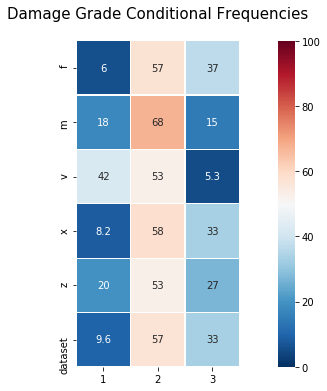

In [58]:
dmgs = df.merge(damages, right_index=True, left_index=True).loc[:,[col,'damage_grade']]
cmap = pd.DataFrame(columns=np.sort(df[col].unique()), index=np.arange(1,4)).fillna(0)
for i in cmap.columns:
    cmap[i] = dmgs[dmgs[col] == i]['damage_grade'].value_counts().sort_index()/len(dmgs[dmgs[col] == i])*100
cmap = cmap.T.fillna(0)
cmap.loc["dataset",:] = damages['damage_grade'].value_counts()/len(damages)*100
colormap = plt.cm.RdBu_r
plt.figure(figsize=(14,6))
plt.title('Damage Grade Conditional Frequencies', y=1.05, size=15)
sns.heatmap(cmap.fillna(100).astype(float) ,linewidths=0.1, vmax=100, vmin=0,
            square=True, cmap=colormap, linecolor='white', annot=True)

In [59]:
expected_value = pd.DataFrame(index=cmap.index, columns=["expected_value_damage", "frequency"])
for i in expected_value.index:
    expected_value.loc[i,"expected_value_damage"] = cmap.loc[i,1]+cmap.loc[i,2]*2+cmap.loc[i,3]*3
expected_value["frequency"] = df[col].value_counts().sort_index()/len(df)*100
(expected_value/100).sort_values(by="expected_value_damage")

,expected_value_damage,frequency
v,1.6342,0.094370
m,1.97047,0.001949
z,2.07371,0.003853
dataset,2.23827,NaN
x,2.25071,0.095460
f,2.3091,0.804368


There are too few buildings with ground_floor_type == m or z. I will merge tis 2 categories in preprocessing.

# Other floor type

other_floor_type (type: categorical): type of constructions used in higher than the ground floors (except of roof). Possible values: j, q, s, x.

In [60]:
col = "other_floor_type"
df[col].value_counts()

q    165282
x     43448
j     39843
s     12028
Name: other_floor_type, dtype: int64

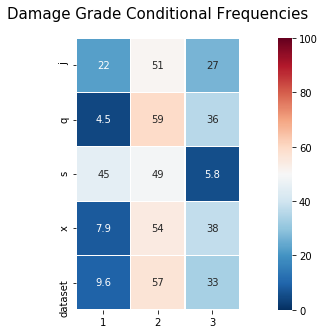

In [61]:
dmgs = df.merge(damages, right_index=True, left_index=True).loc[:,[col,'damage_grade']]
cmap = pd.DataFrame(columns=np.sort(df[col].unique()), index=np.arange(1,4)).fillna(0)
for i in cmap.columns:
    cmap[i] = dmgs[dmgs[col] == i]['damage_grade'].value_counts().sort_index()/len(dmgs[dmgs[col] == i])*100
cmap = cmap.T.fillna(0)
cmap.loc["dataset",:] = damages['damage_grade'].value_counts()/len(damages)*100
colormap = plt.cm.RdBu_r
plt.figure(figsize=(14,5))
plt.title('Damage Grade Conditional Frequencies', y=1.05, size=15)
sns.heatmap(cmap.fillna(100).astype(float) ,linewidths=0.1, vmax=100, vmin=0,
            square=True, cmap=colormap, linecolor='white', annot=True)

In [62]:
expected_value = pd.DataFrame(index=cmap.index, columns=["expected_value_damage", "frequency"])
for i in expected_value.index:
    expected_value.loc[i,"expected_value_damage"] = cmap.loc[i,1]+cmap.loc[i,2]*2+cmap.loc[i,3]*3
expected_value["frequency"] = df[col].value_counts().sort_index()/len(df)*100
(expected_value/100).sort_values(by="expected_value_damage")

,expected_value_damage,frequency
s,1.60742,0.046155
j,2.04289,0.152889
dataset,2.23827,NaN
x,2.29734,0.166722
q,2.31575,0.634234


These categories are well balanced in numbers and have a diversity in damages level probabilities : they will be valuable for training.

# Position

position (type: categorical): position of the building. Possible values: j, o, s, t.

In [63]:
col = "position"
df[col].value_counts()

s    202090
t     42896
j     13282
o      2333
Name: position, dtype: int64

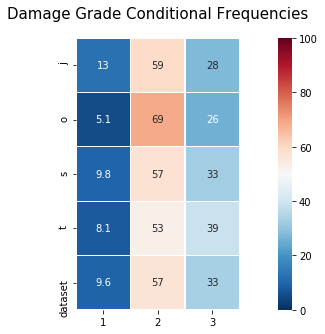

In [64]:
dmgs = df.merge(damages, right_index=True, left_index=True).loc[:,[col,'damage_grade']]
cmap = pd.DataFrame(columns=np.sort(df[col].unique()), index=np.arange(1,4)).fillna(0)
for i in cmap.columns:
    cmap[i] = dmgs[dmgs[col] == i]['damage_grade'].value_counts().sort_index()/len(dmgs[dmgs[col] == i])*100
cmap = cmap.T.fillna(0)
cmap.loc["dataset",:] = damages['damage_grade'].value_counts()/len(damages)*100
colormap = plt.cm.RdBu_r
plt.figure(figsize=(14,5))
plt.title('Damage Grade Conditional Frequencies', y=1.05, size=15)
sns.heatmap(cmap.fillna(100).astype(float) ,linewidths=0.1, vmax=100, vmin=0,
            square=True, cmap=colormap, linecolor='white', annot=True)

In [65]:
expected_value = pd.DataFrame(index=cmap.index, columns=["expected_value_damage", "frequency"])
for i in expected_value.index:
    expected_value.loc[i,"expected_value_damage"] = cmap.loc[i,1]+cmap.loc[i,2]*2+cmap.loc[i,3]*3
expected_value["frequency"] = df[col].value_counts().sort_index()/len(df)*100
(expected_value/100).sort_values(by="expected_value_damage")

,expected_value_damage,frequency
j,2.15306,0.050967
o,2.20746,0.008952
s,2.22913,0.775477
dataset,2.23827,NaN
t,2.3094,0.164604


These categories are quite balanced in numbers and have a diversity in damages level probabilities : they will be valuable for training.

# Plan configuration 

plan_configuration (type: categorical): building plan configuration. Possible values: a, c, d, f, m, n, o, q, s, u.

In [66]:
col = "plan_configuration"
df[col].value_counts()

d    250072
q      5692
u      3649
s       346
c       325
a       252
o       159
m        46
n        38
f        22
Name: plan_configuration, dtype: int64

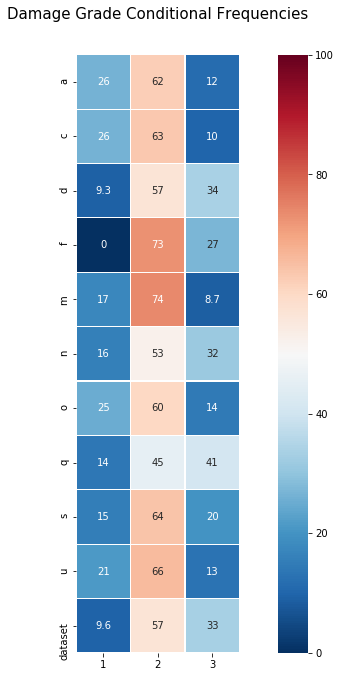

In [67]:
dmgs = df.merge(damages, right_index=True, left_index=True).loc[:,[col,'damage_grade']]
cmap = pd.DataFrame(columns=np.sort(df[col].unique()), index=np.arange(1,4)).fillna(0)
for i in cmap.columns:
    cmap[i] = dmgs[dmgs[col] == i]['damage_grade'].value_counts().sort_index()/len(dmgs[dmgs[col] == i])*100
cmap = cmap.T.fillna(0)
cmap.loc["dataset",:] = damages['damage_grade'].value_counts()/len(damages)*100
colormap = plt.cm.RdBu_r
plt.figure(figsize=(14,11))
plt.title('Damage Grade Conditional Frequencies', y=1.05, size=15)
sns.heatmap(cmap.fillna(100).astype(float), linewidths=0.1, vmax=100, vmin=0,
            square=True, cmap=colormap, linecolor='white', annot=True)

In [68]:
expected_value = pd.DataFrame(index=cmap.index, columns=["expected_value_damage", "frequency"])
for i in expected_value.index:
    expected_value.loc[i,"expected_value_damage"] = cmap.loc[i,1]+cmap.loc[i,2]*2+cmap.loc[i,3]*3
expected_value["frequency"] = df[col].value_counts().sort_index()/len(df)*100
(expected_value/100).sort_values(by="expected_value_damage")

,expected_value_damage,frequency
c,1.83692,0.001247
a,1.85317,0.000967
o,1.89308,0.000610
m,1.91304,0.000177
u,1.91833,0.014002
s,2.04913,0.001328
n,2.15789,0.000146
dataset,2.23827,NaN
d,2.24365,0.959597
q,2.27143,0.021842


These categories are to unevenly distributed. Considering that I will apply one-hot encoding to categorical features, this one will give 8 new features.. it may be a problem. I will probably replace each category by its mean and (nb(damages=1)+nb(damages=3)) / nb(damages=2)

# Legal ownership status

legal_ownership_status (type: categorical): legal ownership status of the land where building was built. Possible values: a, r, v, w.

In [69]:
col = "legal_ownership_status"
df[col].value_counts()

v    250939
a      5512
w      2677
r      1473
Name: legal_ownership_status, dtype: int64

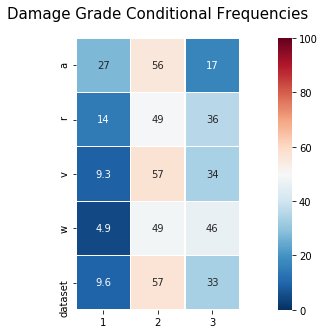

In [70]:
dmgs = df.merge(damages, right_index=True, left_index=True).loc[:,[col,'damage_grade']]
cmap = pd.DataFrame(columns=np.sort(df[col].unique()), index=np.arange(1,4)).fillna(0)
for i in cmap.columns:
    cmap[i] = dmgs[dmgs[col] == i]['damage_grade'].value_counts().sort_index()/len(dmgs[dmgs[col] == i])*100
cmap = cmap.T.fillna(0)
cmap.loc["dataset",:] = damages['damage_grade'].value_counts()/len(damages)*100
colormap = plt.cm.RdBu_r
plt.figure(figsize=(14,5))
plt.title('Damage Grade Conditional Frequencies', y=1.05, size=15)
sns.heatmap(cmap.fillna(100).astype(float), linewidths=0.1, vmax=100, vmin=0,
            square=True, cmap=colormap, linecolor='white', annot=True)

In [71]:
expected_value = pd.DataFrame(index=cmap.index, columns=["expected_value_damage", "frequency"])
for i in expected_value.index:
    expected_value.loc[i,"expected_value_damage"] = cmap.loc[i,1]+cmap.loc[i,2]*2+cmap.loc[i,3]*3
expected_value["frequency"] = df[col].value_counts().sort_index()/len(df)*100
(expected_value/100).sort_values(by="expected_value_damage")

,expected_value_damage,frequency
a,1.89405,0.021151
r,2.21724,0.005652
dataset,2.23827,NaN
v,2.24406,0.962924
w,2.41576,0.010272


Because of its uneven distribution and its name, I assume that this feature is irrelevant and I will remove it.

# Superstructure

has_superstructure_adobe_mud (type: binary): flag variable that indicates if the superstructure was made of Adobe/Mud.

has_superstructure_mud_mortar_stone (type: binary): flag variable that indicates if the superstructure was made of Mud Mortar - Stone.

has_superstructure_stone_flag (type: binary): flag variable that indicates if the superstructure was made of Stone.

has_superstructure_cement_mortar_stone (type: binary): flag variable that indicates if the superstructure was made of Cement Mortar - Stone.

has_superstructure_mud_mortar_brick (type: binary): flag variable that indicates if the superstructure was made of Mud Mortar - Brick.

has_superstructure_cement_mortar_brick (type: binary): flag variable that indicates if the superstructure was made of Cement Mortar - Brick.

has_superstructure_timber (type: binary): flag variable that indicates if the superstructure was made of Timber.

has_superstructure_bamboo (type: binary): flag variable that indicates if the superstructure was made of Bamboo.

has_superstructure_rc_non_engineered (type: binary): flag variable that indicates if the superstructure was made of non-engineered reinforced concrete.

has_superstructure_rc_engineered (type: binary): flag variable that indicates if the superstructure was made of engineered reinforced concrete.

has_superstructure_other (type: binary): flag variable that indicates if the superstructure was made of any other material.

In [72]:
cols = df.loc[:,'has_superstructure_adobe_mud':'has_superstructure_other'].columns

Let's first take a look at the expected value of damage for each superstructure. I will compute 4 values : 
- expected value of damage for buildings with this specific superstructure (expected_value_damage_1_all)
- expected value of damage for buildings with only this specific superstructure (expected_value_damage_1_exclusive)
- expected value of damage for buildings without this specific superstructure (expected_value_damage_0)
- frequency of buildings with this specific superstructure in the dataset (frequency_1_all)

In [73]:
dmgs = df.merge(damages, right_index=True, left_index=True).loc[:,cols.tolist() +['damage_grade']]
expected_value = pd.DataFrame(index=cols, columns=["expected_value_damage_1_all", "expected_value_damage_1_exclusive", 
                                                   "expected_value_damage_0", "frequency_1_all", "frequency_1_exclusive"])
for i in expected_value.index:
    expected_value.loc[i, "expected_value_damage_1_all"] = dmgs[dmgs[i] == 1]['damage_grade'].mean()
    s = dmgs[dmgs[i] == 1].drop(columns=["damage_grade"]).T.sum()
    index = s[s==1].index
    expected_value.loc[i, "expected_value_damage_1_exclusive"] = dmgs.loc[index,'damage_grade'].mean()
    expected_value.loc[i, "expected_value_damage_0"] = dmgs[dmgs[i] == 0]['damage_grade'].mean()
    expected_value.loc[i, "frequency_1_all"] = len(dmgs[dmgs[i] == 1])/len(dmgs)
    expected_value.loc[i, "frequency_1_exclusive"] = len(index)/len(dmgs)
expected_value

,expected_value_damage_1_all,expected_value_damage_1_exclusive,expected_value_damage_0,frequency_1_all,frequency_1_exclusive
has_superstructure_adobe_mud,2.34678,2.36174,2.22772,0.0886451,0.0277397
has_superstructure_mud_mortar_stone,2.3379,2.3749,1.91941,0.761935,0.526222
has_superstructure_stone_flag,2.45255,2.57329,2.23065,0.0343322,0.00471218
has_superstructure_cement_mortar_stone,1.96759,2.01246,2.2433,0.0182348,0.0036953
has_superstructure_mud_mortar_brick,2.27121,2.23812,2.23586,0.068154,0.0235763
has_superstructure_cement_mortar_brick,1.6933,1.62933,2.28263,0.0752683,0.0387796
has_superstructure_timber,2.16522,1.65248,2.26327,0.254988,0.0197428
has_superstructure_bamboo,2.11172,1.68465,2.25003,0.0850112,0.00369914
has_superstructure_rc_non_engineered,1.77953,1.47132,2.25868,0.04259,0.01599
has_superstructure_rc_engineered,1.37551,1.33423,2.25218,0.0158595,0.00995391


We can identify the most efficient superstructure : rc engineered and rc non engineered. They are slightly better when used alone.
On the other hand, buildings witn only stone flag (0.47% of dataset) are condemned to suffer significant damages.


I will now take a look at the number of superstructures per building and the associated expected value of damage grade.

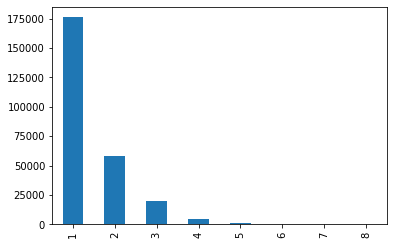

In [74]:
df[cols].T.sum().value_counts().plot.bar()

In [75]:
expected_value = pd.Series(index=np.arange(1,9))
for i in expected_value.index:
    s = df[cols].T.sum()
    index = s[s == i].index
    expected_value[i] = damages.loc[index,"damage_grade"].mean()
expected_value

1    2.263090
2    2.166638
3    2.201781
4    2.340305
5    2.251787
6    2.238854
7    2.028571
8    2.250000
dtype: float64

The number of superstructure have a little or no influence on damages.

# Secondary use

has_secondary_use (type: binary): flag variable that indicates if the building was used for any secondary purpose.

has_secondary_use_agriculture (type: binary): flag variable that indicates if the building was used for agricultural purposes.

has_secondary_use_hotel (type: binary): flag variable that indicates if the building was used as a hotel.

has_secondary_use_rental (type: binary): flag variable that indicates if the building was used for rental purposes.

has_secondary_use_institution (type: binary): flag variable that indicates if the building was used as a location of any institution.

has_secondary_use_school (type: binary): flag variable that indicates if the building was used as a school.

has_secondary_use_industry (type: binary): flag variable that indicates if the building was used for industrial purposes.

has_secondary_use_health_post (type: binary): flag variable that indicates if the building was used as a health post.

has_secondary_use_gov_office (type: binary): flag variable that indicates if the building was used fas a government office.

has_secondary_use_use_police (type: binary): flag variable that indicates if the building was used as a police station.

has_secondary_use_other (type: binary): flag variable that indicates if the building was secondarily used for other purposes.

In [76]:
cols = df.loc[:,'has_secondary_use':'has_secondary_use_other'].columns

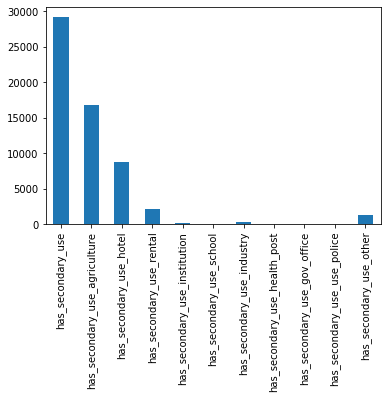

In [77]:
df[cols].sum().plot.bar()

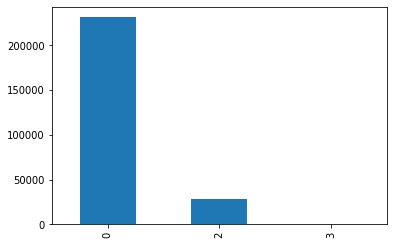

In [78]:
df[cols].T.sum().value_counts().plot.bar()

Buildings have either 0, 2 or 3 secondary use. At this point, I wonder if has_secondary_use is always associated with another secondary use feature and reciprocally.

In [79]:
df[df['has_secondary_use'] ==1][cols].T.sum().value_counts()

2    28599
3      557
dtype: int64

In [80]:
df[cols].T.sum().value_counts()

0    231445
2     28599
3       557
dtype: int64

So has_secondary_use can be remove because this feature can be obtained with the others

In [81]:
dmgs = df.merge(damages, right_index=True, left_index=True).loc[:,cols.tolist() +['damage_grade']]
expected_value = pd.DataFrame(index=cols, columns=["expected_value_damage", "frequency"])
for i in expected_value.index:
    expected_value.loc[i, "expected_value_damage"] = dmgs[dmgs[i] == 1]['damage_grade'].mean()
    expected_value.loc[i, "frequency"] = len(dmgs[dmgs[i] == 1])/len(dmgs) * 100
expected_value.sort_values(by="expected_value_damage")

,expected_value_damage,frequency
has_secondary_use_institution,1.66531,0.0940135
has_secondary_use_rental,1.67125,0.810051
has_secondary_use_gov_office,1.76316,0.0145817
has_secondary_use_health_post,1.85714,0.0188027
has_secondary_use_school,1.8617,0.0360705
has_secondary_use_hotel,1.91704,3.36261
has_secondary_use_industry,2.03226,0.10706
has_secondary_use_other,2.09895,0.511894
has_secondary_use,2.10101,11.188
has_secondary_use_use_police,2.13043,0.00882575


In preprocessing, I will merge together [has_secondary_use_institution and has_secondary_use_rental], [has_secondary_use_health_post and has_secondary_use_gov and has_secondary_use_school],  [has_secondary_use_hotel and has_secondary_use_industry and has_secondary_use_other]		